Build Predictive Model Based on Historical Data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Load Data
gift_df = pd.read_excel("/content/ASU Gift Record 20250106 ANONYMIZED.xlsx")
constituent_df = pd.read_excel("/content/ASU Constituent Records 20250106 ANONYMIZED.xlsx")
rfm_df = pd.read_excel("/content/RFM Score Computation.xlsx")

In [5]:
# Preprocess Gift Data
gift_df["Date"] = pd.to_datetime(gift_df["Date"], errors="coerce")
gift_df["Year"] = gift_df["Date"].dt.year

In [6]:
# Extract 2023 Features
gift_2023 = gift_df[gift_df["Year"] == 2023]
features_2023 = gift_2023.groupby("ConstituentLookupId").agg(
donation_count_2023=("Amount", "count"),
total_donation_2023=("Amount", "sum"),
avg_donation_2023=("Amount", "mean"),
last_donation_2023=("Date", "max")
).reset_index()
features_2023["recency_days_2023"] = (pd.to_datetime("2023-12-31") - features_2023["last_donation_2023"]).dt.days

In [7]:
# Extract 2024 Target
gift_2024 = gift_df[gift_df["Year"] == 2024]
target_2024 = gift_2024.groupby("ConstituentLookupId").agg(
total_donation_2024=("Amount", "sum")
).reset_index()

In [8]:
# Preprocess Constituent and RFM Data
constituent_df = constituent_df.rename(columns={"Constituent ID": "ConstituentLookupId"})
rfm_df = rfm_df.rename(columns={"Donor ID": "ConstituentLookupId"})
constituent_basic = constituent_df[["ConstituentLookupId", "City", "State", "Constituent type"]]
rfm_basic = rfm_df[["ConstituentLookupId", "R Score", "F Score", "M Score", "RFM Score", "Segment"]]
rfm_df = rfm_df[rfm_df["Year"] == 2023]

In [9]:
# Merge Features and Target
model_data = features_2023.merge(constituent_basic, on="ConstituentLookupId", how="left")
model_data = model_data.merge(rfm_basic, on="ConstituentLookupId", how="left")
model_data = model_data.merge(target_2024, on="ConstituentLookupId", how="left")
model_data["total_donation_2024"] = model_data["total_donation_2024"].fillna(0)
model_data.fillna({'City': 'Unknown', 'State': 'Unknown', 'Segment': 'Unknown'}, inplace=True)
model_data.head()

,ConstituentLookupId,donation_count_2023,total_donation_2023,avg_donation_2023,last_donation_2023,recency_days_2023,City,State,Constituent type,R Score,F Score,M Score,RFM Score,Segment,total_donation_2024
0,5,1,10.00,10.00,2023-12-07,24,Maricopa,AZ,Individual,4,1,1,6,General Donor,129.58
1,5,1,10.00,10.00,2023-12-07,24,Maricopa,AZ,Individual,4,1,1,6,General Donor,129.58
2,5,1,10.00,10.00,2023-12-07,24,Maricopa,AZ,Individual,5,5,2,12,Active Donor,129.58
3,6,12,249.36,20.78,2023-12-31,0,Tempe,AZ,Individual,5,4,2,11,Active Donor,239.14
4,6,12,249.36,20.78,2023-12-31,0,Tempe,AZ,Individual,4,5,3,12,Frequent Donor,239.14


In [10]:
# Prepare Features and Target Variables
drop_cols = ['ConstituentLookupId', 'last_donation_2023', 'total_donation_2024']
X = model_data.drop(columns=drop_cols)
y = model_data['total_donation_2024']
X_encoded = pd.get_dummies(X)
X_encoded[['R Score', 'F Score', 'M Score', 'RFM Score']] = X_encoded[
['R Score', 'F Score', 'M Score', 'RFM Score']
].fillna(0)

In [11]:
# Train-Test Split and Modeling
X_train, X_test, y_train, y_test = train_test_split(
X_encoded, y, test_size=0.2, random_state=42
)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [12]:
# Evaluate Model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE: ${rmse:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing R²: {test_r2:.4f}")

RMSE: $1193.14
Training R²: 0.9791
Testing R²: 0.9364


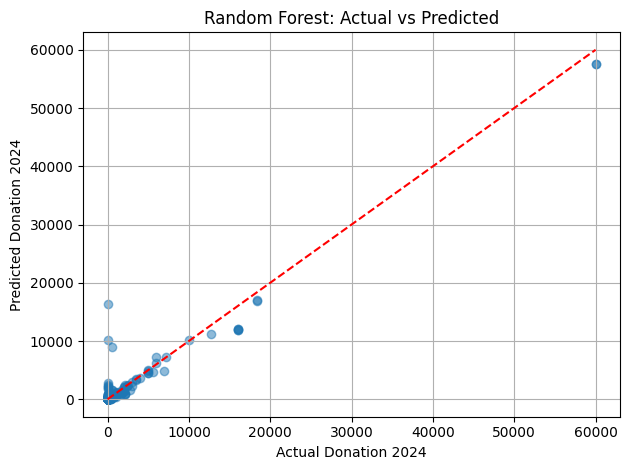

In [13]:
# Plot Actual vs Predicted (Testing)
def plot_actual_vs_predicted(y_true, y_pred, model_name="Random Forest"):
    plt.scatter(y_true, y_pred, alpha=0.5)  # Indented this line
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Indented this line
    plt.xlabel("Actual Donation 2024")  # Indented this line
    plt.ylabel("Predicted Donation 2024")  # Indented this line
    plt.title(f"{model_name}: Actual vs Predicted")  # Indented this line
    plt.grid(True)  # Indented this line
    plt.tight_layout()  # Indented this line
    plt.show()  # Indented this line
plot_actual_vs_predicted(y_test, y_test_pred)

In [15]:
# Check Overfitting
y_train_pred = model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Training R²:", round(train_r2, 4))
print("Testing  R²:", round(test_r2, 4))
print("Training RMSE:", round(train_rmse, 2))
print("Testing  RMSE:", round(test_rmse, 2))

Training R²: 0.9791
Testing  R²: 0.9364
Training RMSE: 496.07
Testing  RMSE: 1193.14


- High R² values indicate that the model explains a large portion of variance in donation behavior.

- Higher RMSE in testing suggests some overfitting, but still within acceptable bounds given prediction complexity.

Predicting 2025 Donations

In [16]:
# Extract 2024 features to predict 2025
features_2024 = gift_2024.groupby("ConstituentLookupId").agg(
    donation_count_2024=("Amount", "count"),
    total_donation_2024=("Amount", "sum"),
    avg_donation_2024=("Amount", "mean"),
    last_donation_2024=("Date", "max")
).reset_index()
features_2024["recency_days_2024"] = (pd.to_datetime("2024-12-31") - features_2024["last_donation_2024"]).dt.days

In [17]:
# Merge with demographic and RFM features
future_pred_data = features_2024.merge(constituent_basic, on="ConstituentLookupId", how="left")
future_pred_data = future_pred_data.merge(rfm_basic, on="ConstituentLookupId", how="left")
future_pred_data.fillna({'City': 'Unknown', 'State': 'Unknown', 'Segment': 'Unknown'}, inplace=True)

In [18]:
# Prepare input for prediction
X_future = future_pred_data.drop(columns=['ConstituentLookupId', 'last_donation_2024', 'total_donation_2024'], errors='ignore')
X_future = pd.get_dummies(X_future)
X_future[['R Score', 'F Score', 'M Score', 'RFM Score']] = X_future[
    ['R Score', 'F Score', 'M Score', 'RFM Score']
].fillna(0)
X_future = X_future.reindex(columns=X_encoded.columns, fill_value=0)

In [19]:
# Predict donations for 2025
future_pred_data["predicted_donation_2025"] = model.predict(X_future)

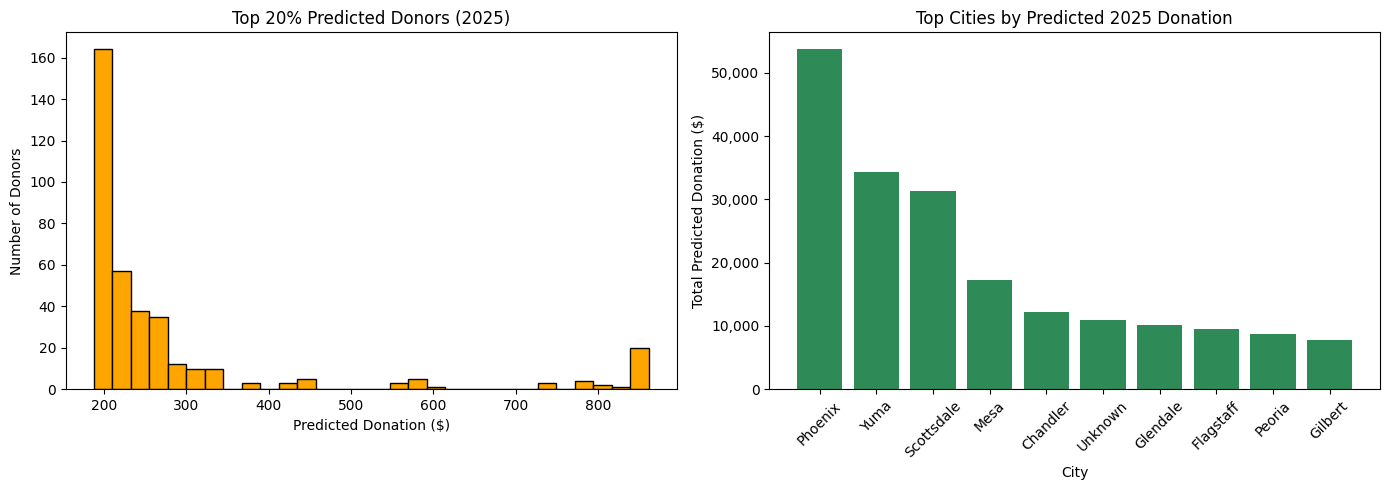

In [22]:
# Plot Top 20% Donors and Top Cities
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
threshold_80 = np.percentile(future_pred_data["predicted_donation_2025"], 80)
top_20_df = future_pred_data[future_pred_data["predicted_donation_2025"] >= threshold_80]

# Left: Top 20% donors' donation histogram
axes[0].hist(top_20_df["predicted_donation_2025"], bins=30, color='orange', edgecolor='black')
axes[0].set_title("Top 20% Predicted Donors (2025)")
axes[0].set_xlabel("Predicted Donation ($)")
axes[0].set_ylabel("Number of Donors")

# Right: Top cities by predicted total donation
top_cities = future_pred_data.groupby("City")["predicted_donation_2025"].sum().sort_values(ascending=False).head(10)
axes[1].bar(top_cities.index, top_cities.values, color='seagreen')
axes[1].set_title("Top Cities by Predicted 2025 Donation")
axes[1].set_xlabel("City")
axes[1].set_ylabel("Total Predicted Donation ($)")
axes[1].tick_params(axis='x', rotation=45)

# Format y-axis to show commas for thousands
axes[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.show()

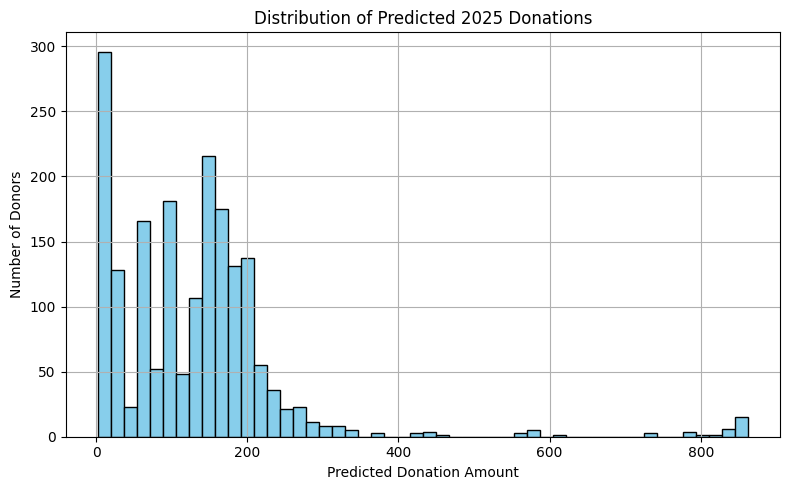

In [23]:
# Plot Distribution of All Predicted Donations
plt.figure(figsize=(8, 5))
plt.hist(future_pred_data["predicted_donation_2025"], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted 2025 Donations")
plt.xlabel("Predicted Donation Amount")
plt.ylabel("Number of Donors")
plt.grid(True)
plt.tight_layout()
plt.show()

While predictions are technically valid, donor-level granularity is weak. The donation amounts are repetitive and clustered, indicating that the model struggles to provide varied, personalized estimates.



Top Donor Table & Repetition Analysis

In [24]:
# Top 50 Predicted Donors Table
top_preds = future_pred_data.sort_values(by="predicted_donation_2025", ascending=False).head(50)
print("Top 50 Donors by Predicted 2025 Donation")
print(top_preds[["ConstituentLookupId", "City", "State", "predicted_donation_2025"]])

Top 50 Donors by Predicted 2025 Donation
      ConstituentLookupId       City State  predicted_donation_2025
965                 79344       Yuma    AZ                 861.9390
948                 79157       Yuma    AZ                 861.9390
1567               111835       Yuma    AZ                 861.9390
967                 79344       Yuma    AZ                 861.0586
954                 79287       Yuma    AZ                 861.0586
966                 79344       Yuma    AZ                 861.0586
1799               119000       Yuma    AZ                 861.0586
949                 79157       Yuma    AZ                 861.0586
955                 79287       Yuma    AZ                 861.0586
1109               101826       Yuma    AZ                 861.0586
1792               118948       Yuma    AZ                 861.0586
1110               101826       Yuma    AZ                 861.0586
1108               101826       Yuma    AZ                 861.0586
319    

In [25]:
# Analyze Duplicate Predicted Values
value_counts = future_pred_data["predicted_donation_2025"].value_counts().sort_values(ascending=False)
print("\nMost Common Predicted Values:")
print(value_counts.head(10))
print(f"\nTotal repeated values (assigned to more than one donor): {sum(value_counts > 1)}")
print(f"Most common prediction value assigned to {value_counts.iloc[0]} donors")


Most Common Predicted Values:
predicted_donation_2025
3.9287      25
158.7668    24
102.4010    20
95.5077     19
14.6430     19
165.7107    18
9.4014      17
155.1197    17
15.7514     16
138.8131    16
Name: count, dtype: int64

Total repeated values (assigned to more than one donor): 345
Most common prediction value assigned to 25 donors


The model's predictions are heavily duplicated, assigning the same dollar amount to dozens of different individuals.
This reduces strategic insight, as the results cannot meaningfully segment or prioritize donors.